# Analyzing A/B Test Results

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

### import libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline


### load data

In [2]:
df = pd.read_csv('ab_data.csv')
print(df.shape)
df.head()

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### About dataset
The dataset consists of 294,478 rows and 5 columns. "user_id" is the unique identifier of the different users that visited the pages. "timestamp" is the time of visit. "group" indicates what category a page visitor falls under, control are those who visited the first page while treatment are those who visited the new page. "landing_page" is the page they tested. Converted indictates whether a page visitor buys the product or not, it is 1 if the individual paid for a product and 0 if they didn't.

### data assessment

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values. It would be more convenient to have timestamp as date_time rather than object

In [4]:
#convert timestamp to datetime
df.timestamp = pd.to_datetime(df.timestamp)

df.timestamp.dtype

dtype('<M8[ns]')

### Messy data
control under group column ought to pair with old_page in landing_page column. Cases where control does not match with old_page and treatment does not match with new_page are wrong entries and have to be removed.

In [5]:
messy_control = df[(df.group == 'control') & (df.landing_page!= 'old_page')]
messy_control.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1


In [6]:
messy_treatment = df[(df.group == 'treatment') & (df.landing_page!= 'new_page')]
messy_treatment.head()

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [7]:
#remove messy data
messy_entries = messy_control.append(messy_treatment)
df_clean = df.drop(messy_entries.index, axis = 0)

#test
print(df_clean[(df.group == 'treatment') & (df.landing_page!= 'new_page')])
df_clean[(df.group == 'control') & (df.landing_page!= 'old_page')]

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,user_id,timestamp,group,landing_page,converted


##### Checking for and dropping duplicates

In [8]:
df_clean.user_id.duplicated().sum()

1

In [9]:
dup_user = df_clean[df_clean.user_id.duplicated()]

df_clean.drop(dup_user.index, axis = 0, inplace = True)
df_clean.user_id.duplicated().sum()

0

## Part A - Probability

In [10]:
#Probability of converting irrespective of group
P_converted = df_clean.converted.mean()
P_converted

0.11959708724499628

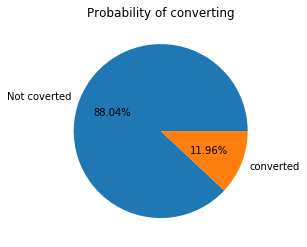

In [11]:
test_a = df_clean.copy()
test_a['convert'] = test_a['converted'].map({0:'Not coverted', 1:'converted'})
vc = test_a['convert'].value_counts()
plt.pie(vc, labels = vc.index, autopct = "%.2f%%")
plt.title('Probability of converting');

###### Probability that an individual in the control group converted

In [12]:
control = df_clean.query('group == "control"')
control_converted = control.query('converted ==1')
P_cc = len(control_converted)/len(control)
P_cc

0.1203863045004612

###### Probability that an individual in the treatment group converted

In [13]:
#Probability of treatment converting
treatment = df_clean.query('group == "treatment"')
treatment_converted = treatment.query('converted ==1')
P_tc = len(treatment_converted)/len(treatment)
P_tc

0.11880806551510564

In [14]:
obs_diff = P_tc - P_cc
obs_diff

-0.0015782389853555567

###### probability that an individual received the new page and old page

In [15]:
new_page = df_clean.query('landing_page == "new_page"')
old_page = df_clean.query('landing_page == "old_page"')

P_new_page = len(new_page) /len(df_clean)
P_old_page = len(old_page) /len(df_clean)
print('new - ',P_new_page,'\nold-', P_old_page)

new -  0.5000619442226688 
old- 0.4999380557773312


Although the probability that an individual recieves the new page is slightly higher, the control seems to have a slightly higher chance of conversion than the treatment compairing P_cc and P_tc.
Based on these probabilities alone, I believe it is better if the company keep the old page.

## Part B - A/B Test

Lets assume the null hypothesis, that both the new and old page have equal success rates which is equal to the converted rate in the main dataset. 


        Null Hypothesis: P_new = P_old

        Alternative Hypothesis: P_new != P_old

In [16]:
P_new = P_converted
P_old = P_converted

In [17]:
#rows length of new and old pages
N_new = len(new_page)
N_old = len(old_page)

###### simulate new converted data based on length of pages and their probabilities of converting
Simulate N_new transactions with a convert rate of P_new under the null.  
Simulate N_old transactions with a convert rate of P_old under the null.

In [18]:
new_page_converted = np.random.choice(2, N_new, p=[(1-P_new), P_new])
old_page_converted = np.random.choice(2, N_old, p=[(1-P_old), P_old])

print('New_page_mean = ', new_page_converted.mean())
print('Old_page_mean = ', old_page_converted.mean())

New_page_mean =  0.118959465969307
Old_page_mean =  0.11883062351143357


###### probability differences between new and old pages from 10,000 simulations

In [19]:
p_diffs = []

for i in range(10000):
    npage_converted = np.random.choice(2, N_new, p=[(1-P_new), P_new])
    opage_converted = np.random.choice(2, N_old, p=[(1-P_old), P_old])
    p_n = npage_converted.mean()
    p_o = opage_converted.mean()
    p_diffs.append(p_n - p_o)

np.mean(p_diffs)

-7.846199494441097e-06

Text(0.5, 1.0, 'Distribution of probability  differences in conversion')

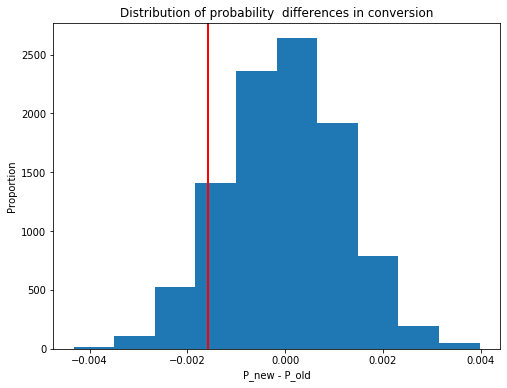

In [20]:
plt.figure(figsize = (8,6))
plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = 'r', linewidth = 2)
plt.xlabel('P_new - P_old')
plt.ylabel('Proportion')
plt.title('Distribution of probability  differences in conversion')

###### proportion of **p_diffs** greater than the actual  probability difference in original dataset

In [21]:
p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9036

What was computed above is the p-value. It gives a measure of the confidence interval for which the null hypothesis stands.

For a p-value above 0.05, we fail to reject the null hypothesis. This means there is no statistical significant difference between the new and old page.

## Part C - A regression approach

Logistic Regression is the most appropriate regression method to use since each group is either converted or not.

In [22]:
df_clean.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [23]:
df_clean['intercept'] = 1
df_clean['ab_page'] = df_clean['group'].map({'control':0, 'treatment':1})
df_clean.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [24]:
#instantiating and fitting model
mod = sm.Logit(df_clean['converted'], df_clean[['intercept', 'ab_page']])
result = mod.fit()

#Result Summary
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-05-25 10:34 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

p-value associated with ab_page is 0.1899


It differs from the value in Part II because the two null hypothesis are not thesame. The null hypothesis with the regression model is P_old >= P_new, where as the null hypothesis in part II is  P_old = P_new.


The p_value  suggests that 'ab_page' alone is not suficient to explain the convertion rate and not enough statistical significance to reject the null hypothesis. 

Adding other factors, e.gcountries may explain our regression model better.

In [25]:
countries_df = pd.read_csv('./countries.csv')

#join countries dataset with main dataset
df_new = countries_df.set_index('user_id').join(df_clean.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [26]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [27]:
#creating necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


##### checking model behaviour with addition of countries

In [28]:
mod_1 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','CA','UK']])
result_1 = mod_1.fit()
result_1.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-05-25 10:34 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

The different p_values  do not provide statistical significance to reject the null hypothesis

###### Country interaction with ab_page

In [29]:
df_new['CA_new'] = df_new['ab_page'] * df_new['CA']
df_new['UK_new'] = df_new['ab_page'] * df_new['UK']

In [30]:
mod_1 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','CA', 'UK','CA_new','UK_new']])
result_1 = mod_1.fit()
result_1.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-05-25 10:34 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Even with countries interaction, there seems to be no statistical significance to fail to reject the null hypothesis

## Conclusions

With the available data and analysis carried out, and all other factors remaining fairly constant, **I would suggest the e-commerce company keep the old page.**
